In [ ]:
colab=False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    chdir('/content/drive/MyDrive/BI - Data/')
    
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD

In [1]:
#https://github.com/GuyAllard/markov_clustering
%pip install markov_clustering

import markov_clustering as mc
import statistics
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
import json
import sys
import os

Note: you may need to restart the kernel to use updated packages.


# 1) Data Gathering

As first stage is important to download the files in BioGRID to obtain the main human interactome:

In [11]:
def make_seeds_splits(DGA,HSN):
    
    random.seed(10)
    seed_genes = list(set.intersection(set(DGA['geneSymbol'].tolist()), set(HSN['Official Symbol Interactor A'].tolist()).union(HSN['Official Symbol Interactor B'].tolist())))
    with open("seed_gene.txt",'w') as f:
        f.write(str(seed_genes))
    f.close()
    print('# disease genes in PPI ', len(seed_genes))
    
    splits = {}
    for i in range(0,5):
        start = len(seed_genes)//5*i
        splits[i]=seed_genes[start:start + len(seed_genes)//5]
    if len(seed_genes)>len(seed_genes)//5:
        splits[1]+=seed_genes[len(seed_genes):]
        
    with open('splits.json', 'w') as fp:
        json.dump(splits, fp)
    
    return seed_genes,splits

def import_seeds_split():
    with open("seed_gene.txt",'r') as f:
        seeds = f.readlines()
    with open('splits.json') as json_file:
        splits = json.load(json_file)
    
    return seeds, splits

def interactome_processing(filepath):
    '''
    Filter out self-loops
    Filter out repetitive interactions ([A-B,B-A] or [A-B,A-B] or [B-A,B-A])
    Filter out interactions that are not physical
    '''
    HSN = pd.read_csv(filepath, sep = "\t")
    HSN = HSN[HSN['Organism Name Interactor A'] == HSN['Organism Name Interactor B']]
    HSN = HSN[HSN['Official Symbol Interactor A'] != HSN['Official Symbol Interactor B']]
    HSN = HSN[HSN['Experimental System Type'] == "physical"]
    return HSN

def DGA_processing(filepath, disease):
    '''
    Filter for disease of interest
    '''
    DGA = pd.read_csv(filepath, sep = '\t')
    DGA = DGA[DGA['diseaseName'] == disease]
    return DGA

def make_disease_graph(HSN, DGA, DG_in_PPI):
    '''
    Print Disease LCC size and returns graph with all nodes
    '''
    DN = HSN[HSN["Official Symbol Interactor A"].isin(DGA["geneSymbol"]) & HSN["Official Symbol Interactor B"].isin(DGA["geneSymbol"])] 
    G= nx.Graph()
    G.add_nodes_from(DG_in_PPI)
    G.add_edges_from(list(zip(map(int, DN["Entrez Gene Interactor A"]), map(int, DN["Entrez Gene Interactor B"]))))
    print('# nodes in disease LCC ',max([len(G) for G in sorted(nx.connected_components(G), key=len, reverse=True)]))
    return G

def extract_LCC_form_PPI(HSN):
    '''
    Creates graph and returns LCC. Prints LCC size. Save graph adj. matrix as file.
    '''
    PPI = nx.Graph()
    PPI.add_nodes_from(map(int, list(set(HSN["Entrez Gene Interactor A"].tolist() + HSN["Entrez Gene Interactor B"].tolist()))))
    PPI.add_edges_from(list(zip(map(int, HSN["Entrez Gene Interactor A"]), map(int, HSN["Entrez Gene Interactor B"]))))
    LCCs = [len(PPI) for PPI in sorted(nx.connected_components(PPI), key=len, reverse=True)]
    LCC = PPI.subgraph(max(nx.connected_components(PPI), key=len))
    print('# nodes ',len(max(nx.connected_components(PPI), key=len)),', # connections ', len(LCC.edges()))
    nx.write_adjlist(LCC, "PPI.adjlist")
    
    return LCC

def plot_LCC(LCC, DG_in_PPI):
    fig = plt.figure(1, figsize=(8, 8))
    color_map = []
    for node in LCC:
        if node in DG_in_PPI:
            color_map.append('red')
        else: 
            color_map.append('blue')      

    nx.draw(LCC, node_color=color_map, node_size=3)
    plt.show()
    


##### LCC in PPI #####


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# nodes  19620 , # connections  665061
##### Disease Network #####
# nodes in disease LCC  2


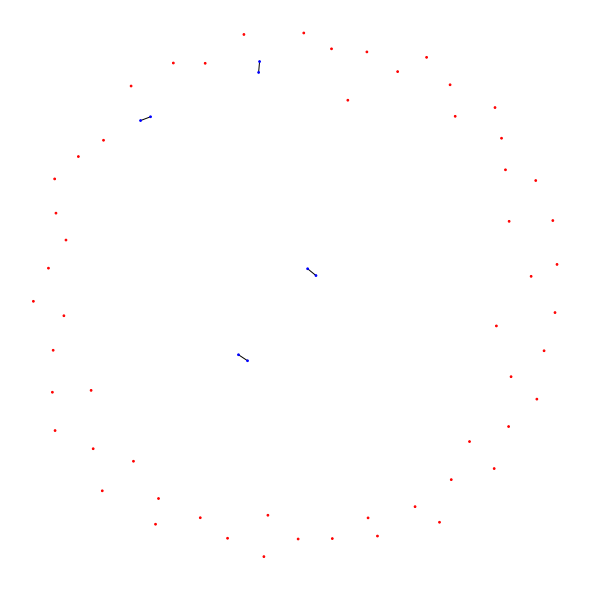

In [12]:
print('##### LCC in PPI #####')
HSN = interactome_processing("BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA = DGA_processing('curated_gene_disease_associations.tsv', 'Libman-Sacks Disease')
#DG_in_PPI,splits = make_seeds_splits(DGA,HSN)
DG_in_PPI, splits = import_seeds_split()
LCC = extract_LCC_form_PPI(HSN)


print('##### Disease Network #####')
DN = make_disease_graph(HSN, DGA, DG_in_PPI)
plot_LCC(DN, DG_in_PPI)

In [13]:
print(splits)

{'0': ['TNFAIP3', 'DNASE1L3', 'RASGRP1', 'TLR5', 'C1QA', 'FCGR2A', 'DNASE1', 'PRDM1', 'CRP', 'HLA-DQA1', 'DEF6'], '1': ['TREX1', 'CR2', 'PTGS2', 'IL21', 'P2RY12', 'BLK', 'ANXA3', 'CFB', 'CSK', 'IL6', 'RASGRP3'], '2': ['CD226', 'SIGLEC6', 'CTLA4', 'CAT', 'IL4', 'IFIH1', 'CLU', 'ITGAM', 'PRL', 'TCF7', 'IL21R'], '3': ['IL10', 'ETS1', 'PTPN22', 'IRF5', 'CLEC16A', 'SLC15A4', 'NCF1', 'FCGR2B', 'IRAK4', 'UHRF1BP1', 'TERT'], '4': ['SH2B3', 'IKZF1', 'IL12B', 'PDCD1', 'HLA-DRB1', 'PXK', 'BANK1', 'SYNGR1', 'TNIP1', 'STAT4', 'JAZF1']}


In [20]:
geneDiseaseIDs = {
    '0': DGA[DGA.geneSymbol.isin(splits['0'])].geneId.tolist(),
    '1': DGA[DGA.geneSymbol.isin(splits['1'])].geneId.tolist(),
    '2': DGA[DGA.geneSymbol.isin(splits['2'])].geneId.tolist(),
    '3': DGA[DGA.geneSymbol.isin(splits['3'])].geneId.tolist(),
    '4': DGA[DGA.geneSymbol.isin(splits['4'])].geneId.tolist()
}

def calculate_dcg(inters, cv, alg_name):
  dcg = 0
  try:
    for dis_gene in inters:
      rank = cv.loc[cv[alg_name + '_node'] == dis_gene].index.tolist()[0]
      dcg += 1/np.log2(rank+1)
  except:
    dcg += 0

  return dcg

def normalized_dcg(ndcg_scores):
  return list(np.around(np.array(ndcg_scores)/np.max(ndcg_scores), 3)) # normalizing the results of DCG by its maximum value

def evaluation(top_n, cval, alg_name):
    recalls, precs, f1s, ndcg_scores = ([] for _ in range(4))

    cv = pd.read_csv(f'first_1000_added_nodes_weight_1.txt',sep='\t')
    cv_nodes = cv[alg_name + '_node'].tolist()
    top = set(cv_nodes[0:top_n]) # subsetting each cross by 1000, 500 etc.

    inters = top.intersection(geneDiseaseIDs[str(i)]) # intersect with the probe set

    ## Calculating the DCG
    dcg = calculate_dcg(inters, cv, alg_name)

    ## Appends the results
    recall = round(len(inters)/cval, 3)
    prec = round(len(inters)/top_n, 3)

    ## Appends the results
    recalls.append(recall)
    precs.append(prec)
    ndcg_scores.append(round(dcg, 3))

    try:
      f1s.append(round(2*((recall*prec)/(recall+prec)), 3))
    except:
      f1s.append(0)

    return {'recall': recalls, 
            'precision': precs, 
            'F1 Score': f1s, 
            'ndcg': normalized_dcg(ndcg_scores)}

# 2) Algorithms to be used for the heuristic tasks

--> **DIAMOnD**

In [25]:
def diamond(LCC, seeds, splits, i, top_n, path):
    # filtering the splits at i-th iteration
    filteredSymbolGenes_ID = DGA[DGA.geneSymbol.isin(splits[str(i)])].geneId.tolist()
    actualDt = list(set(seeds) - set(filteredSymbolGenes_ID))

    textfile = open("seed_gene.txt", "w")
    for element in actualDt:
      textfile.write(str(element) + '\n')
    textfile.close()
    
    pairs_genes = list(LCC.edges)
    textfile = open("PPI_Libman.txt", "w")
    for gA, gB in tqdm(pairs_genes):
        textfile.write(str(gA) + ',' + str(gB) + '\n') 
    textfile.close()
    
    # da implementare for loop che cambia i seed genes secondo gli split pre definiti
    !python3  DIAMOnD/DIAMOnD.py  PPI_Libman.txt  seed_gene.txt  top_n #aumentare da 100 a 500 
    !mv first_1000_added_nodes_weight_1.txt str(f'first_1000_added_nodes_weight_1_Key{i}.txt')
    
    for x in [1000,500,250,100]:
        print(x, evaluation(x, cval = len(splits['0']), alg_name = 'DIAMOnD'))
    print('\n')
    
    !mv str(f'first_1000_added_nodes_weight_1_Key{i}.txt') str('./path/')

--> **DiaBLE**

In [ ]:
    '''
    --> to be modified in DiaBLE code <--
    after line 317 
    candidates = set(cluster_nodes)
    universe = set()
    for _ in range(0, 2):
        for gene in candidates.copy():
            universe |= neighbors[gene]
            candidates = universe        
    N = len(universe)
    ''' 
    
    '''
    modifies line 415
    fout.write('\t'.join(['#rank', 'DiaBLE_node', 'p_hyper']) + '\n')
    '''

--> **MCL**

In [ ]:
def MCL(LCC,seeds,splits):
    adj_mat = nx.adjacency_matrix(LCC)
    recalls = []
    precs = []
    for inflation in [i / 10 for i in range(14, 18)]:
        result = mc.run_mcl(adj_mat, inflation=inflation)
        clusters = mc.get_clusters(result)
        #Q = mc.modularity(matrix=result, clusters=clusters)
        for idx in range(0,5):
            test = set(splits[idx])
            training = set(seeds).difference(test)
            positives = set()
            recall = 0
            prec = 0
            for cluster in clusters:
                if len(set(cluster).intersection(training)) != 0:
                    positives = positives.union(cluster)
            inters = test.intersection(positives)
            recall += len(inters)/(len(positives)+10e-10)
            prec += len(inters)/(len(test)+10e-10)
        recalls.append(recall/5)
        precs.append(prec/5)
            
        print("inflation:", inflation,', modularity', ", # clusters:", len(clusters),', max #nodes in cluster:', max([len(cluster) for cluster in clusters]),', mean #nodes in cluster:', statistics.mean([len(cluster) for cluster in clusters]))
    return recalls,precs

## 2.1 MCL 

In [ ]:
MCL_rec, MCL_prec = MCL(LCC,DG_in_PPI,splits)

## 2.2 DIAMOnD/DiaBLE

In [24]:
!mkdir DIAMOnD_results
!mkdir DiaBLE_results

for i in range(0, 5):
    diamond(LCC, DG_in_PPI, splits, i, top_n = 1000, path = 'DIAMOnD_results')

100%|██████████████████████████████████████████████████████████████████████| 665061/665061 [00:00<00:00, 671100.14it/s]


 
        usage: python3 DIAMOnD.py network_file seed_file n alpha(optional) outfile_name (optional)
        -----------------------------------------------------------------
        network_file : The edgelist must be provided as any delimiter-separated
                       table. Make sure the delimiter does not exit in gene IDs
                       and is consistent across the file.
                       The first two columns of the table will be
                       interpreted as an interaction gene1 <==> gene2
        seed_file    : table containing the seed genes (if table contains
                       more than one column they must be tab-separated;
                       the first column will be used only)
        n            : desired number of DIAMOnD genes, 200 is a reasonable
                       starting point.
        alpha        : an integer representing weight of the seeds,default
                       value is set to 1
        outfile_name : results will

"mv" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


FileNotFoundError: [Errno 2] File first_1000_added_nodes_weight_1.txt does not exist: 'first_1000_added_nodes_weight_1.txt'

## 2.4 Diffusion-based algorithm 

In [ ]:
def DB_algorithm(seeds)
    precision=[]
    recall=[]
    random.seed(123)
    for i in range(1,11):
        random.shuffle(seeds)
        cross=pd.read_csv('/content/cross {} results.csv'.format(i),sep=',')
        cross=cross[cross['selected']==True]
        cross=cross[cross['diffusion_input']==0]
        cross=cross.sort_values(by='diffusion_output_rank')
        par_prec=[]
        par_rec=[]
        for top in [100,1000,2000]:
            check=set(cross[0:top]['name'].tolist())
            P=len(check.intersection(seeds))
            par_prec.append(P/top)
            par_rec.append(P/56)
        precision.append(par_prec)
        recall.append(par_rec)


print(precision)
print(recall)

In [ ]:
cross=pd.read_csv('/content/cross 1 results.csv',sep=',')
#cross=cross[cross['selected']==True]
cross=cross[cross['diffusion_input']==0]
cross=cross.sort_values(by='diffusion_output_rank')
a=set(cross[0:19000]['name'].tolist())
a.intersection(seeds)

## 2.5 MOSES (Optional)

Guide: https://wiki.opencog.org/w/Python#MOSES_from_Python

## 2.6 Random Walk with Restart (Optional)

To be done...

# 4) Extended Validation

# 5) EnrichR

This section should be done re-coding whole of the operations seen before